# CBS Week 12 Assessment: Categorization
## Semester 2 2023


In [12]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(mvtnorm)
    library(ggpubr)
    library(ggrepel)
    library(metR)
    library(testthat)
    library(knitr)
    library(kableExtra)
    library(IRdisplay)
    options(repr.plot.width=8, repr.plot.height=8)
})

# a function for displaying tables
show_table <- function(d) {
    kable(d, "html", align="c")  %>% 
        as.character()  %>% 
        display_html()
}

This notebook is due at 8 am on **October 30** (note that this is 3 days after the date originally announced). Please make sure that your notebook validates before you submit it --- if your notebook doesn't validate the automated grader may run into issues.

In the Week 11 tutorial you looked at one-dimensional categorization problems, and this notebook applies an exemplar model to a two-dimensional categorization problem. We'll use data from an experiment reported by Nosofsky (1989), [Further tests of an exemplar similarity approach to relating identification and categorization](  https://link.springer.com/content/pdf/10.3758/BF03204942.pdf ).  The same paper also describes an exemplar model called the GCM (Generalized Context Model) that is related to but not the same as the exemplar model used in this notebook. The 1989 paper is difficult to read, and a more accessible overview of the GCM is given by  Nosofsky (2011), [The generalized context model: an exemplar model of classification](  
https://nosofsky.cogs.indiana.edu/pubs/Nosofsky_2014_chapter.pdf ), which also includes an application of the model to the 1989 data set (see pp 29 -34). Looking at this 2011 chapter may help you think about some of the questions in this notebook, but this notebook can be completed without reading the chapter.

Nosofsky's experiments used a set of 16 semi-circles that vary on two dimensions -- the size of the semi-circle and the angle of the radius shown. These 16 stimuli can be organized into a grid.


<figure>
  <img src="images/nosofsky_stim.png" alt="nosofsky_stim" style="width:50%">
  <figcaption  class="figure-caption text-center">Figure 1: Stimuli used by Nosofsky (1989). Figure reproduced from the 1989 paper.</figcaption>
</figure>

One of the things that interested Nosofsky is that people might weight these dimensions differently -- e.g. they might be more sensitive to differences in size than differences in angle. Our exemplar model, however, will give the dimensions the same weight. For convenience, we'll scale the dimensions so that along each dimension the stimuli have a mean of zero and a standard deviation of one.

Nosofsky's experiment included 4 conditions that are summarized by the figure below. Don't worry about the small numbers at the top of each square.


<figure>
  <img src="images/nosofsky_conditions.png" alt="nosofsky_conditions" style="width:50%">
  <figcaption  class="figure-caption text-center">Figure 2: The four conditions in the experiment of Nosofsky (1989). Figure reproduced from the 2011 chapter.</figcaption>
</figure>

In each condition participants had to classify all 16 stimuli, but they were only given feedback indicating the true category labels for a subset of the stimuli. For example, in the criss-cross condition the feedback indicated that stimuli 4,7,10 and 13 belonged to category 1 and that stimuli 1,2,15 and 16 belonged to category 2. We're interested in how participants used this feedback to generalize to all of the other stimuli in the grid.

Let's start by loading a file with Nosofsky's data, and making a plot to show the 16 stimuli after scaling both dimensions.


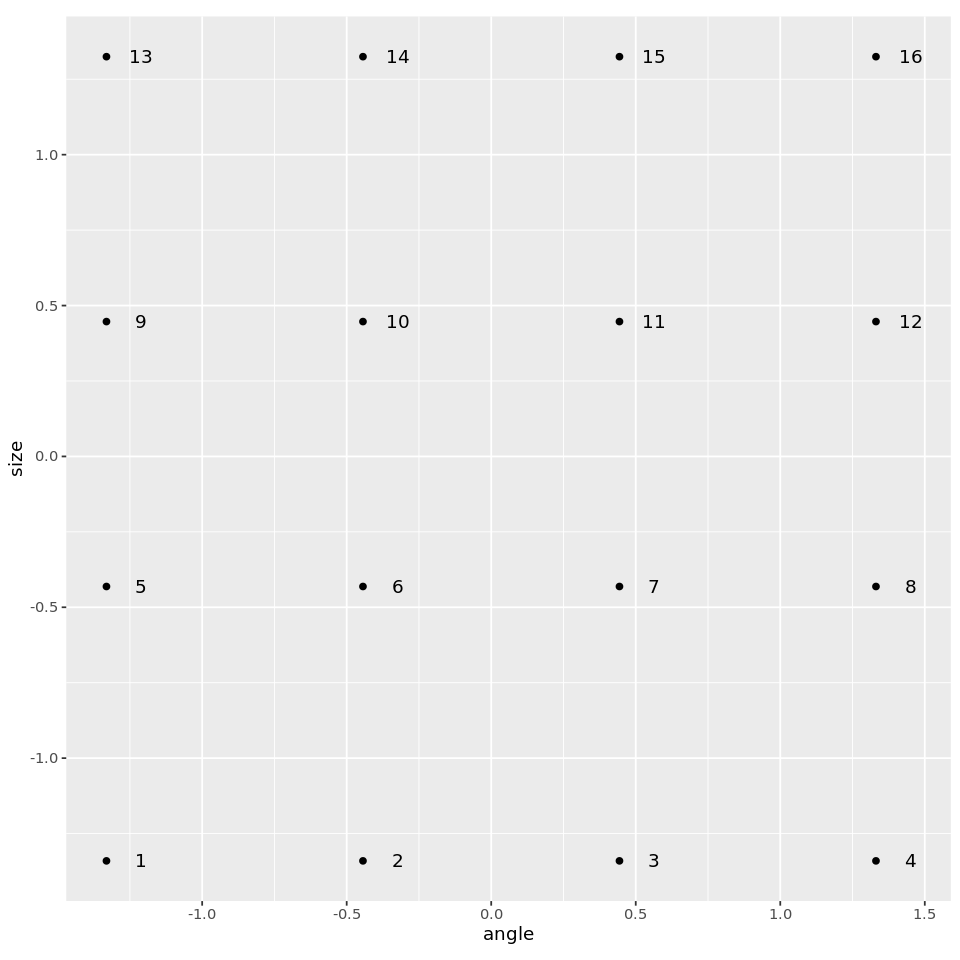

In [13]:
conditions = c("size", "angle", "crisscross", "diagonal")

ndata <- read_csv("nosofsky89_categorization_data.csv", show_col_types = FALSE) %>% 
  # scale angle and size so that both have zero mean and unit standard deviation
  mutate(angle = scale(angle), size = scale(size)) %>% 
  mutate(x = map2(angle, size, c)) %>% 
  mutate(condition=factor(condition, levels=conditions)) %>% 
  mutate(z = factor(z))

nstim <- ndata %>% 
  select(stim_id, angle, size, x) %>% 
  unique()

stimplot <- nstim  %>% 
  ggplot(aes(x=angle, y=size, label=stim_id)) +
  geom_point() +
  geom_text(nudge_x = 0.12) +
  theme(aspect.ratio=1)

print(stimplot)

As for the week 11 notebook, we'll use $z$ to denote the category label of an object. We'd like to compute a classification function  $P(z=1|x)$ that we can use to estimate the probability that a new object $x$ anywhere in the 2 dimensional space belongs to category 1.

Bayes rule tells us that $P(z=1|x) \propto P(x|z) P(z=1)$. Let's start with a function for computing the likelihood $P(x|z)$.  An exemplar model estimates $P(x|z=1)$ by dropping a Gaussian kernel (ie a Gaussian bump) on each exemplar of category 1, adding up all these kernels, and renormalizing to make sure that the density integrates to 1.  Because we're looking at a two-dimensional problem, the Gaussian bumps are 2-dimensional Gaussian distributions. We'll assume that these distributions are axis-aligned Gaussians, which means that they can be characterized by a variance along the angle dimension and a variance along the size dimension. To keep things simple we'll set both variances to 1.


In [14]:
# We'll use an axis-aligned Gaussian kernel where the variance along each dimension (or bandwidth) is 1.
# Changing this parameter will affect the predictions of the model.

bw <- 1
bw_2d <- diag(c(bw, bw))

# compute p(XNEW|z=CATEGORY)  based on the observations in DATA
p_x_given_z <- function(data, category, xnew, bw = bw_2d){
  newval <- data %>% 
    filter(z == category) %>% 
    mutate(k_val = map_dbl(x, ~dmvnorm(xnew, mean = ., sigma = bw))) %>% 
    summarize(mean_k_val = mean(k_val)) %>% 
    pull()
}

We'll also need a function to compute the prior.  We'll assume that $P(z=1)$ corresponds to the proportion of observed examples that belong to category 1. 



In [15]:
# compute p(z=CATEGORY) based on the observations in DATA
p_z <- function(data, category){
  sum(data$z == category, na.rm = TRUE)/( sum(!is.na(data$z)) )
}

Now let's set up a function to combine the prior and likelihood in order to compute the posterior $P(z=1|x)$. 

### Question 1 (1 point)

The function here has some errors --  you'll need to fix it so that the columns `p_z1_given_x` and `p_z2_given_z` are computed correctly. These two columns should capture $P(z=1|x)$ and $P(z=2|x)$ respectively.


In [16]:
# DATA includes exemplars that have been labelled (ie our training data)
# NEWPOINTS includes points that we'd like to classify

classification_curve <- function(data, newpoints, bw = bw_2d) {
  classifications <- newpoints %>% 
    # compute p(z) for all x
    mutate(p_z1 = p_z(data, 1)) %>% 
    mutate(p_z2 = p_z(data, 2)) %>% 
    # compute p(x|z) 
    mutate(p_x_given_z1 = map_dbl(x, ~p_x_given_z(data, 1, ., bw))) %>% 
    mutate(p_x_given_z2 = map_dbl(x, ~p_x_given_z(data, 2, ., bw))) %>% 
    # you'll need to fix the next four lines of code
    # compute p(z|x) up to normalizing constant
    mutate(p_z1_given_x = 0.5) %>% 
    mutate(p_z2_given_x = 0.5) %>% 
    # normalize p(z|x) 
    mutate(p_z1_given_x = 0.5) %>% 
    mutate(p_z2_given_x = 0.5) %>%
    ### BEGIN SOLUTION
    # there are four columns to define -- give 0.25 points for each one
    mutate(p_z1_given_x = p_x_given_z1*p_z1) %>% 
    mutate(p_z2_given_x = p_x_given_z2*p_z2) %>% 
    # normalize p(z|x) 
    mutate(p_z1_given_x = p_z1_given_x /(p_z1_given_x + p_z2_given_x)) %>% 
    mutate(p_z2_given_x =  1-p_z1_given_x)
    ### END SOLUTION
}  

In [17]:
# Please make sure that your code passes this test before continuing!
newpointgrid <- tibble(angle = 0, size = 0)  %>%  mutate(x = map2(angle, size, c))
gridclassification <-  ndata %>% 
  group_by(condition) %>% 
  nest() %>% 
  mutate(classifications = map(data, classification_curve, newpointgrid, bw_2d)) %>% 
  unnest(classifications)
expect_equal(gridclassification$p_z1_given_x, c(0.4463648, 0.6465739, 0.4983925, 0.5534889), tol = 0.001)

We'll use the function just defined to classify all points in a grid that ranges from -2 to 2 along each dimension. We'll start by looking at the distributions $P(x|z=1)$ (red contour plot) and $P(x|z=2)$ (blue contour plot) for each condition.



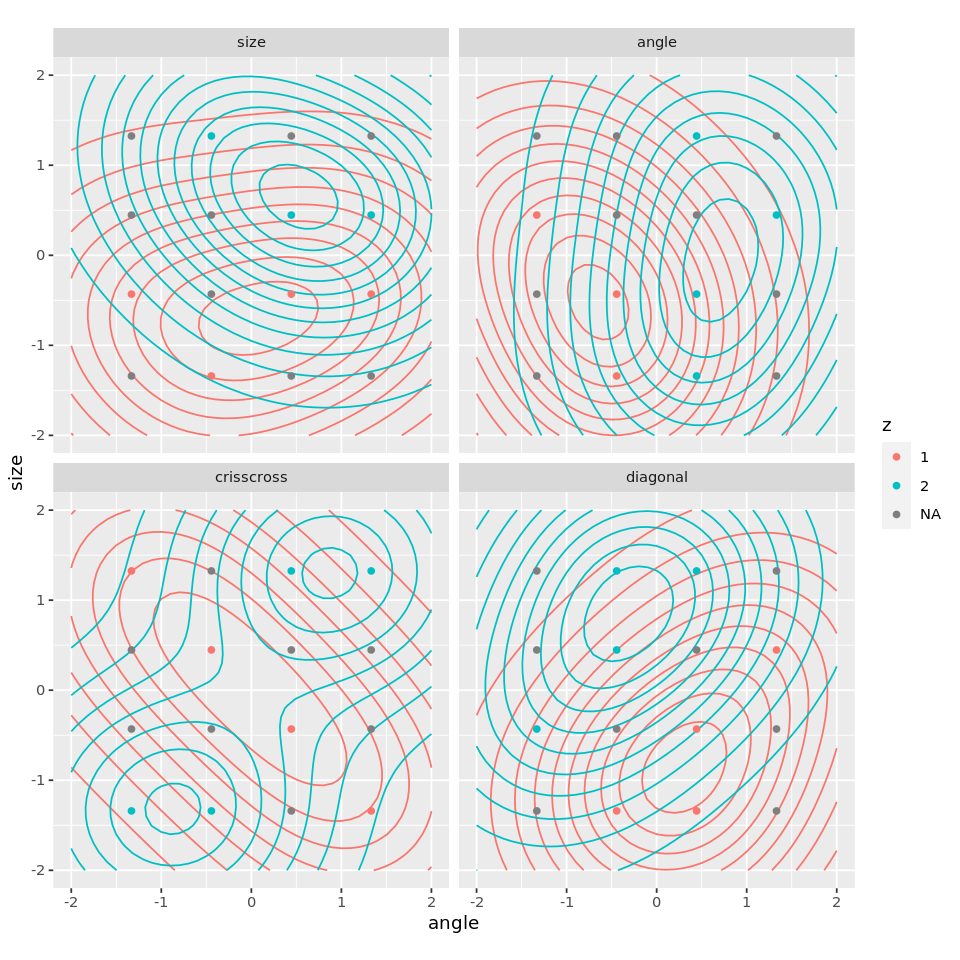

In [18]:
newpointgrid <- expand_grid(angle = seq(-2, 2, 0.1), size = seq(-2, 2, 0.1)) %>% 
  mutate(x = map2(angle, size, c)) 

gridclassification <-  ndata %>% 
  group_by(condition) %>% 
  nest() %>% 
  mutate(classifications = map(data, classification_curve, newpointgrid, bw_2d)) %>% 
  unnest(classifications)

densityplot <- gridclassification %>% 
  ggplot(aes(angle, size)) +
  geom_contour(aes(z=p_x_given_z1), color="#F8766D") +
  geom_contour(aes(z=p_x_given_z2), color = "#00BFC4") +
  facet_wrap(~condition) +
  geom_point(data=ndata, aes(color=z))  +
  theme(aspect.ratio=1) 

print(densityplot)

### Question 2 (1 point)

For the criss-cross condition, the distribution $P(x|z=2)$ has two peaks. Where do these peaks lie? 

=== BEGIN MARK SCHEME ===

The first peak lies between stimuli 1 and 2 at roughly (-0.9, -1.2). The second peak lies between stimuli 15 and 16 at roughly (0.9, 1.2)

=== END MARK SCHEME ===

For each condition we can also plot the classification surface $P(z=1|x)$. The contour on this surface where $P(z=1|x)=0.5$ separates regions that are classified as category 1 from regions that are classified as category 2.

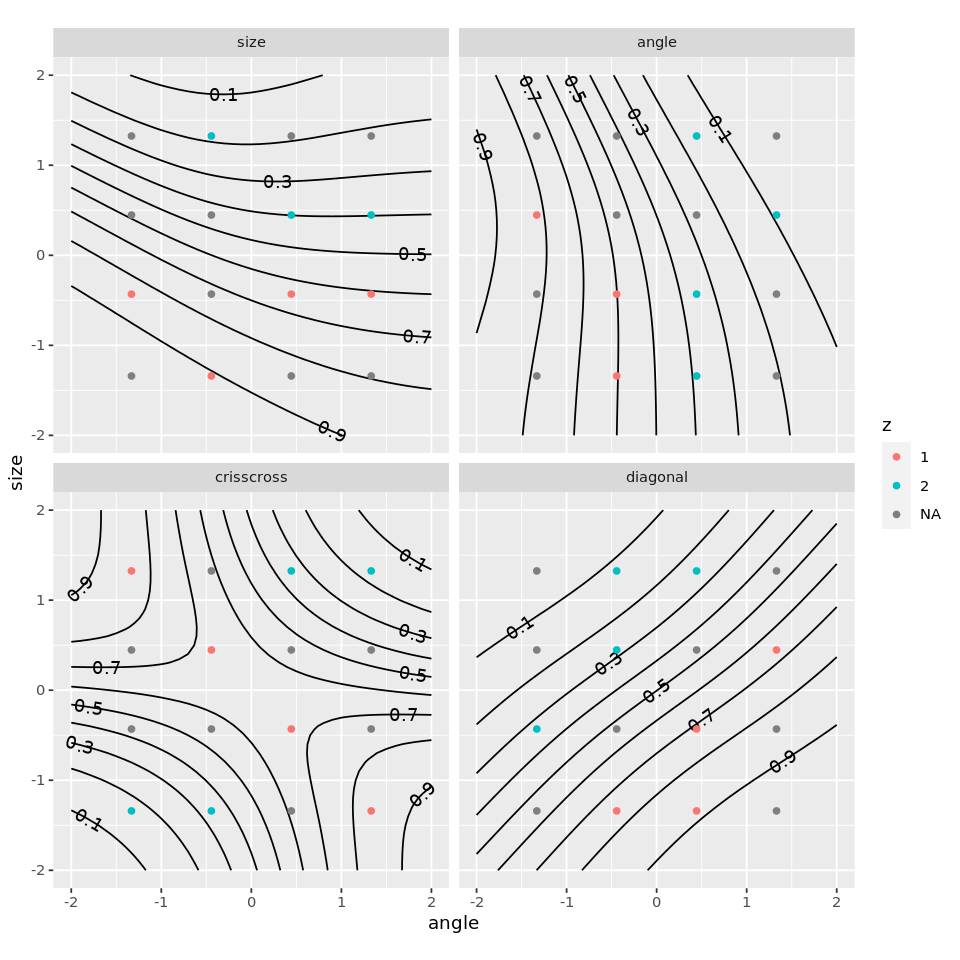

In [19]:
classificationsurface <- gridclassification %>% 
  ggplot(aes(angle, size)) +
  geom_contour(aes(z=p_z1_given_x), color="black") +
  geom_text_contour(aes(z=p_z1_given_x)) +
  facet_wrap(~condition) +
  geom_point(data=ndata, aes(color=z)) +
  theme(aspect.ratio=1) 

print(classificationsurface)

### Question 3 (1 point)

For each condition, which of the 16 exemplars are assigned to category 1 by the exemplar model? Provide your answer by adding to the lists below. For example, you should edit `size_classified_as_z1` so that it includes the full list of exemplars assigned to category 1 by the model in the size condition (currently this list includes only exemplars 2, 5, 7 and 8). The exemplar labels are based on the plot above that shows the 16 exemplars numbered from 1 to 16.


In [20]:
size_classified_as_z1<- c(2,5,7,8)
angle_classified_as_z1<- c()
crisscross_classified_as_z1 <- c()
diagonal_classified_as_z1 <- c()

### BEGIN SOLUTION
# response for each condition is worth 0.5 points
size_classified_as_z1<- c(1,2,3,4,5,6,7,8,9)
angle_classified_as_z1<- c(1,2,5,6,9,10,13)
crisscross_classified_as_z1 <- c(3,4,6,7,8,9,10,11,13,14)
diagonal_classified_as_z1 <- c(1,2,3,4,6,7,8,12)
### END SOLUTION

In [21]:
# this cell contains tests (including some hidden tests) that your answer to Question 3 should pass
expect_gt(length(angle_classified_as_z1), 0) 
expect_gt(length(crisscross_classified_as_z1), 0) 
expect_gt(length(diagonal_classified_as_z1), 0) 
### BEGIN HIDDEN TESTS
expect_equal(sort(size_classified_as_z1),  c(1,2,3,4,5,6,7,8,9) ) 
expect_equal(sort(angle_classified_as_z1),  c(1,2,5,6,9,10,13) ) 
expect_equal(sort(crisscross_classified_as_z1), c(3,4,6,7,8,9,10,11,13,14) ) 
expect_equal(sort(diagonal_classified_as_z1), c(1,2,3,4,6,7,8,12) ) 
### END HIDDEN TESTS

To generate the plots above we applied the exemplar model to every point on a grid that ranges from -2 to 2 along each dimension. Now we'll apply the model to the 16 experimental stimuli only. In each condition, the model assigns each stimulus a probability of belonging to category 1. We'll compare these probabilities with Nosofsky's experimental data -- ie with the proportion of times each stimulus was assigned to category 1 by his participants.

In [22]:
allconditions <- ndata %>% 
  group_by(condition) %>% 
  nest() %>% 
  mutate(classifications = map(data, classification_curve, nstim, bw_2d))

Now we'll make a dataframe that pairs each stimulus in each condition with a "model probability" (ie $P(z=1|x)$ according to the model) and a "human probability" (ie the proportion of participants who assigned the stimulus to category 1). For each stimulus we'll compute the squared error -- ie the square of the difference between the model probability and the human probability. 



In [23]:
humanvsmodel <- allconditions %>% 
    unnest(cols=c(classifications)) %>% 
    select(condition, stim_id, p_z1_given_x ) %>% 
    rename(model_p_z1_given_x = p_z1_given_x ) %>% 
    left_join(ndata, by=c("stim_id", "condition")) %>% 
    mutate(squared_error= (model_p_z1_given_x - human_p_z1_given_x)^2) %>% 
    group_by(condition) %>% 
    mutate(sse = round(sum(squared_error), 2)) 

humanvsmodel %>% 
    head()  %>% 
    show_table()

condition,stim_id,model_p_z1_given_x,angle,size,z,human_p_z1_given_x,x,squared_error,sse
angle,1,0.7881196,-1.331118,-1.3404749,NA,0.9634146,"-1.331118, -1.340475",0.0307284,0.28
angle,2,0.6033706,-0.443706,-1.3404749,1,0.5719557,"-0.443706, -1.340475",0.0009869,0.28
angle,3,0.3889211,0.443706,-1.3404749,2,0.1568627,"0.443706, -1.340475",0.0538511,0.28
angle,4,0.2066946,1.331118,-1.3404749,NA,0.0243902,"1.331118, -1.340475",0.0332349,0.28
angle,5,0.8153282,-1.331118,-0.4311469,NA,0.9878049,"-1.3311180, -0.4311469",0.0297482,0.28
angle,6,0.6013007,-0.443706,-0.4311469,1,0.6620209,"-0.4437060, -0.4311469",0.0036869,0.28


Now we can plot human probabilities against model probabilities. The 4 panels show results for the 4 conditions, and each data point in each panel is labelled with a stimulus number. We've added a diagonal line, and if the model performed perfectly then all of the data points would lie along this line (ie model probabilities would be identical to human probabilities). The "squared error" associated with a point is the square of its vertical distance from the diagonal line.  Each panel is annotated with a SSE (sum squared error) value that represents the sum of the squared errors across all 16 stimuli in a condition.



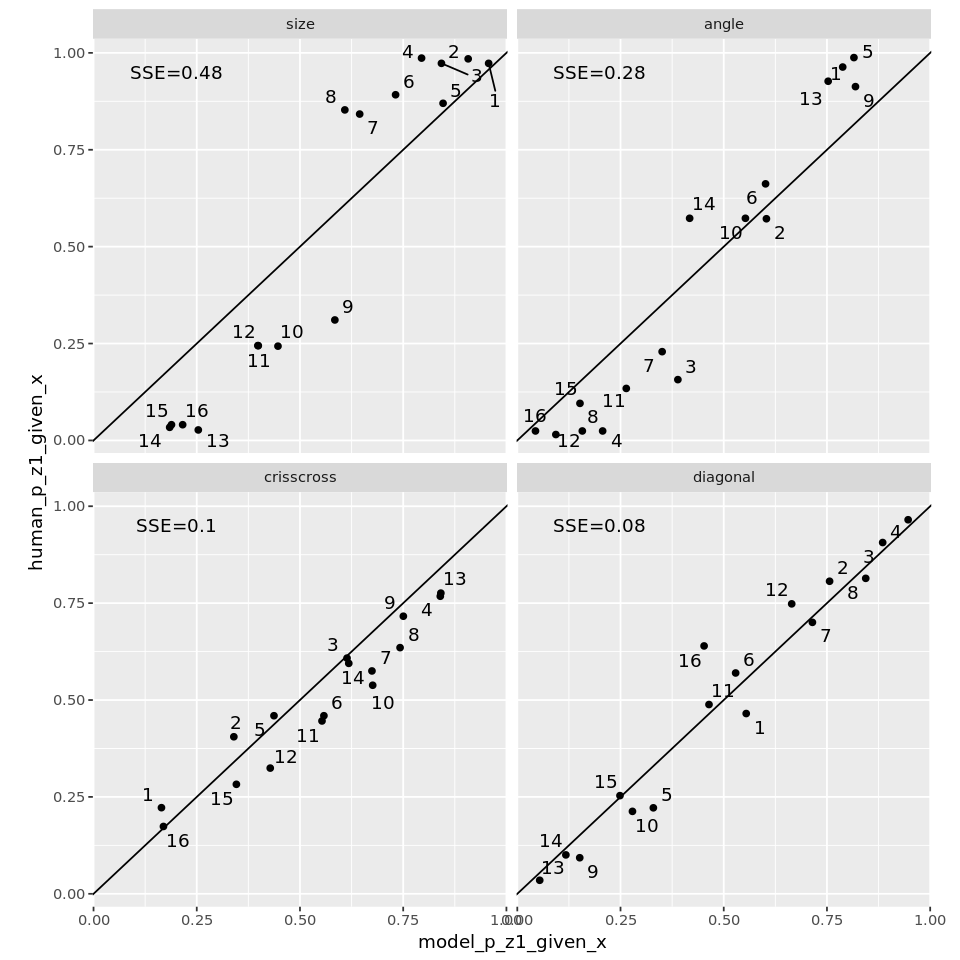

In [16]:
sselabs <- humanvsmodel %>% 
   select(condition, sse) %>% 
   unique()
  
humanvsmodelplot <- humanvsmodel %>% 
  ggplot(aes(x=model_p_z1_given_x, y=human_p_z1_given_x, label=stim_id))  +
  geom_point() +
  geom_abline(intercept=0, slope=1) +
  geom_text_repel() +
  geom_text(data=sselabs, aes(x=0.2, y = 0.95, label=paste0("SSE=",sse)))   +
  theme(aspect.ratio=1) +
  facet_wrap(~condition)

print(humanvsmodelplot)

### Question 4 (2 points)

You should see that the overall sum of squared errors (SSE) is higher for the size and angle conditions than for the crisscross and diagonal conditions. Why do you think that the model performance is worse for the size and angle conditions than for the other two conditions? Your answer should contain two components: (i) a statement of a way in which the size and angle conditions differ from the other two conditions (ii) an explanation of why this difference might lead to poorer model performance on the size and angle conditions.


=== BEGIN MARK SCHEME ===

(i) (1 point) In the size and angle conditions, the difference between the categories can be characterized in terms of a single dimension (let's call it the "dominant dimension").  For example, the training data for the size condition are compatible with a rule which says that an object belongs to category 1 if it has a value less than 0 on the size dimension, and otherwise belongs to category 2. For the angle condition, the angle dimension is dominant. In the remaining two conditions, a rule that refers to one dimension only is not enough to separate the two categories.

(ii)  (1 point) In the size and angle conditions, it's natural to think that people treat the dominant dimension as more important than the other -- we could say that they weight this dimension more heavily, or pay more attention to this dimension. Our model, however, weights the two dimensions equally, because the Gaussian kernel is assumed to have the same variance along both dimensions. The model therefore performs best on the conditions (criss cross and diagonal) where people must pay attention to both dimensions.

=== END MARK SCHEME ===

In [ ]:
# use this cell if needed to write code for Question 5

Now that you've thought about the overall performance for the 4 conditions, let's zoom in and think about responses to individual stimuli.

### Question 5 (1 point)

For which condition and stimulus number is there the greatest discrepancy between model probabilities and human probabilities? Use the `humanvsmodel` dataframe to answer this question.

=== BEGIN MARK SCHEME ===

Stimulus 9 in the size condition

=== END MARK SCHEME ===

### Question 6 (1 point)

Why does the exemplar model predict that the stimulus you just identified probably belongs to category 1?

=== BEGIN MARK SCHEME ===

In the size condition the labeled exemplar closest to stimulus 9 is stimulus 5, which belongs to category 1. The nearest labeled exemplar has the biggest influence on the model's prediction, so it makes sense that the model assigns stimulus 9 to category 1.

=== END MARK SCHEME ===

### Question 7 (1 point)

Why do you think that people tend to assign the stimulus you just identified to category 2?

=== BEGIN MARK SCHEME ===

People probably figure out that in the size condition the dimension of size is much more important than the dimension of angle. If we consider the size dimension alone, stimulus 9 is closer to the labeled category 2 exemplars than it is to the labeled category 1 exemplars. 

=== END MARK SCHEME ===

### Question 8 (1 point)

Describe one way in which the model could be adjusted to reduce the discrepancy between model probabilities and human probabilities you identified in Question 5. You don't necessarily need to identify a specific way to adjust the code ---  a high-level description in English will be sufficient.

=== BEGIN MARK SCHEME ===

We could adjust the covariance of the Gaussian kernel so that the variance along the angle dimension is much larger than the variance along the size dimension. This change would effectively weight differences along the size dimension more heavily than differences along the angle dimension. Ideally, the covariance of the kernel would be learned from the labelled training examples rather than specified as a free parameter.

=== END MARK SCHEME ===

Nosofsky's 2011 chapter includes results showing how the GCM performs on the same data set that we've used in this notebook. The plot below shows that the GCM performs very well:

<figure>
  <img src="images/nosofsky_modelresults.png" alt="nosofsky_modelresults" style="width:50%">
  <figcaption  class="figure-caption text-center">Figure 3: Human probabilities plotted against predictions of the GCM. This plot includes results for all four conditions, and is reproduced from the Nosofsky (2011) chapter.</figcaption>
</figure>

The GCM, however, is more complex than the exemplar model considered in this notebook, and includes 3 tuneable parameters rather than 1. For the model in this notebook, the only numerical parameter is the variance (or bandwidth) associated with the Gaussian kernel, which we set to 1.

An important difference between the GCM and the model in this notebook is that the models are defined over different kinds of 2-dimensional spaces. Our model used a *physical* space --- the dimensions of the space were based on physical measurements of the angle and size of the stimuli presented in the experiment. The GCM uses a *psychological* space --- the exemplars are represented as points in a space such that the psychological similarity between two points is a decreasing function of their distance in the space. 

In the 1989 paper Nosofsky estimates the psychological space using data from an identification experiment in which the stimuli are repeatedly presented and participants are asked to identify the size (level 1 through 4) and angle (level 1 through 4) of each stimulus that they see. These data can be used to tell how often one stimulus is confused with another, and these confusion data can be used to estimate the psychological space (stimuli that are often confused should be nearby in the space). The resulting psychological space is shown in the figure below:


<figure>
  <img src="images/nosofsky_mds.png" alt="nosofsky_mds" style="width:50%">
  <figcaption  class="figure-caption text-center">Figure 4: Psychological space used by the GCM. This figure is reproduced from the Nosofsky (1989) chapter.</figcaption>
</figure>

You can see that the stimuli still form a grid, but the grid is a little ragged. For example, the distance between stimuli 13 and 14 is greater than the distance between stimuli 14 and 15. 

### Question 9 (1 point)

For the 16 stimuli in the experiment, people seem to be more sensitive to differences in size than to differences in angle. Explain how we can draw this conclusion from the psychological space represented in Figure 4. 

=== BEGIN MARK SCHEME ===

In Figure 4 the points are more spaced out along the size dimension than along the angle dimension. This asymmetry suggests that people are more sensitive to size than angle --- in particular,  that they are more likely to confuse stimuli that are identical except for angle than they are to confuse stimuli that are identical except for size.

=== END MARK SCHEME ===

Although simple stimuli like the ones Nosofsky used allow for tightly controlled lab experiments, ultimately we would like to explain how people categorize complex real-world objects --- e.g. how radiologists classify X-rays as "normal" or "abnormal", or how dermatologists classify skin lesions as "melanomas" or "non-melanomas." A major challenge when applying psychological models of categorization to real-world problems is to come up with a representation of the underlying psychological space --- ie  the space in which the exemplars are embedded. One possibility is to learn these representations from a large-scale behavioral experiment --- see for example Hebart et al (2020), [Revealing the multidimensional mental representations of natural objects underlying human similarity judgements ]( https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7666026/ ) . Another promising approach is to use representations derived from convolutional neural networks --- see for example  Battleday et al (2020), [ Capturing human categorization of natural images by combining deep networks and cognitive models ]( https://www.nature.com/articles/s41467-020-18946-z.pdf?origin=ppub ).